# Фаза 2 • Неделя 8 • Четверг
## Нейронные сети
### 🔥 PyTorch: fine tuning

### Подготовка к работе

1. Загрузи этот ноутбук на Google Colab
2. Подгрузи архив [датасета](https://www.kaggle.com/datasets/ikobzev/architectural-heritage-elements-image64-dataset) в свое пространство и разархивируй его с помощью `unzip`. 

In [87]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.nn import functional as F
from torchvision import io

import numpy as np
import torchutils as tu
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import mlflow.pytorch
import multiprocessing as mp

# Установите метод запуска процессов на 'spawn'
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)

torch.set_default_device("cuda")
# config = {
#     "batch_size": 2048,
#     "learning_rate": 0.002,
#     "epochs": 10,
#     "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
#     "data_dir": "data/",
#     "log_dir": "runs/experiment1",
# }
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GENERATOR = torch.Generator(device=DEVICE)
BATCH_SIZE = 128
mlflow.set_tracking_uri("http://localhost:5000")

plt.rcParams["figure.dpi"] = 300
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [59]:
def fit_model(
    epochs: int,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.modules.loss.CrossEntropyLoss,
    train_loader,
    valid_loader,
) -> dict:

    history = {
        "train_losses": [],
        "train_accs": [],
        "train_precs": [],
        "train_recals": [],
        "train_f1s": [],
        "valid_losses": [],
        "valid_accs": [],
        "valid_precs": [],
        "valid_recals": [],
        "valid_f1s": [],
    }
    start_epoch = len(history["train_accs"])

    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):
        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        model.train()
        batch_accs = []
        batch_losses = []
        batch_precs = []
        batch_recals = []
        batch_f1s = []

        for samples, labels in train_loader:

            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(samples)

            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            metrics = classification_metrics(labels, y_pred, n_classes)
            batch_losses.append(loss.item())
            batch_precs.append(metrics["precision"])
            batch_accs.append(metrics["accuracy"])
            batch_recals.append(metrics["recall"])
            batch_f1s.append(metrics["f1"])

        history["train_losses"].append(np.mean(batch_losses))
        history["train_accs"].append(np.mean(batch_accs))
        history["train_precs"].append(np.mean(batch_precs))
        history["train_recals"].append(np.mean(batch_recals))
        history["train_f1s"].append(np.mean(batch_f1s))

        model.eval()
        batch_accs = []
        batch_losses = []
        batch_precs = []
        batch_recals = []
        batch_f1s = []
        for samples, labels in valid_loader:
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)
            with torch.no_grad():
                y_pred = model(samples)

            loss = criterion(y_pred, labels)

            metrics = classification_metrics(labels, y_pred, n_classes)
            batch_losses.append(loss.item())
            batch_precs.append(metrics["precision"])
            batch_accs.append(metrics["accuracy"])
            batch_recals.append(metrics["recall"])
            batch_f1s.append(metrics["f1"])

        history["valid_losses"].append(np.mean(batch_losses))
        history["valid_accs"].append(np.mean(batch_accs))
        history["valid_precs"].append(np.mean(batch_precs))
        history["valid_recals"].append(np.mean(batch_recals))
        history["valid_f1s"].append(np.mean(batch_f1s))

        # [MLflow] Логируем метрики
        if use_mlflow:
            # epoch – номер шага (можно указывать step=epoch)
            mlflow.log_metric("train_loss", history["train_losses"][-1], step=epoch)
            mlflow.log_metric("train_acc", history["train_accs"][-1], step=epoch)
            mlflow.log_metric("train_prec", history["train_precs"][-1], step=epoch)
            mlflow.log_metric("train_recal", history["train_recals"][-1], step=epoch)
            mlflow.log_metric("train_f1", history["train_f1s"][-1], step=epoch)
            mlflow.log_metric("valid_loss", history["valid_losses"][-1], step=epoch)
            mlflow.log_metric("valid_acc", history["valid_accs"][-1], step=epoch)
            mlflow.log_metric("valid_prec", history["valid_precs"][-1], step=epoch)
            mlflow.log_metric("valid_recal", history["valid_recals"][-1], step=epoch)
            mlflow.log_metric("valid_f1", history["valid_f1s"][-1], step=epoch)

        print(
            f'Train: loss {history["train_losses"][-1]:.4f}\n'
            f'accuracy {history["train_accs"][-1]:.4f}, F1-score {history["train_f1s"][-1]:.4f}\n'
            f'precision {history["train_precs"][-1]:.4f}, recal {history["train_recals"][-1]:.4f}\n'
            f'Valid: loss {history["valid_losses"][-1]:.4f}\n'
            f'accuracy {history["valid_accs"][-1]:.4f}, F1-score {history["valid_f1s"][-1]:.4f}\n'
            f'precision {history["valid_precs"][-1]:.4f}, recal {history["valid_recals"][-1]:.4f}\n'
        )
        print(f'{"-"*35}')
        print()

    return history

In [60]:
def classification_metrics(
    y_true: torch.Tensor, y_pred: torch.Tensor, num_classes: int
):
    """
    Считает Accuracy, Precision и Recall для мультиклассовой классификации.

    Аргументы:
        y_true (Tensor): Истинные метки (shape: [N])
        y_pred (Tensor): Предсказанные метки (shape: [N])
        num_classes (int): Количество классов

    Возвращает:
        dict: {'accuracy': float, 'precision': Tensor[num_classes], 'recall': Tensor[num_classes]}
    """
    # Убедимся, что всё на одной видеокарте
    device = y_true.device
    y_pred = y_pred.to(device)
    y_pred = y_pred.argmax(axis=1)
    # Accuracy
    accuracy = (y_true == y_pred).float().mean().item()

    # Матрица ошибок
    conf_matrix = torch.zeros(num_classes, num_classes, device=device)
    for t, p in zip(y_true, y_pred):
        conf_matrix[t, p] += 1

    # True Positive, False Positive, False Negative
    TP = conf_matrix.diag()
    FP = conf_matrix.sum(0) - TP
    FN = conf_matrix.sum(1) - TP

    precision_per_class = TP / (TP + FP + 1e-8)
    recall_per_class = TP / (TP + FN + 1e-8)
    f1_per_class = (
        2
        * precision_per_class
        * recall_per_class
        / (precision_per_class + recall_per_class + 1e-8)
    )
    class_weights = conf_matrix.sum(1) / conf_matrix.sum()
    weighted_precision = (precision_per_class * class_weights).sum()
    weighted_recall = (recall_per_class * class_weights).sum()
    weighted_f1 = (f1_per_class * class_weights).sum()

    return {
        "accuracy": accuracy,
        "precision": weighted_precision.item(),
        "recall": weighted_recall.item(),
        "f1": weighted_f1.item(),
    }

In [61]:
def plot_history(history, grid=True, suptitle="model 1"):
    fig, ax = plt.subplots(3, 2, figsize=(16, 20))
    fig.suptitle(suptitle, fontsize=24, fontweight="bold", y=0.85)
    ax[0][0].plot(history["train_losses"], label="train loss")
    ax[0][0].plot(history["valid_losses"], label="valid loss")
    ax[0][0].set_title(f'Loss on epoch {len(history["train_losses"])}', fontsize=16)
    ax[0][0].grid(grid)
    ax[0][0].set_ylim((0, max(history["train_losses"] + history["valid_losses"]) + 0.1))
    ax[0][0].legend(fontsize=14)
    ax[0][0].set_xlabel("Epoch", fontsize=14)
    ax[0][0].set_ylabel("Loss", fontsize=14)

    ax[0][1].plot(history["train_accs"], label="train acc")
    ax[0][1].plot(history["valid_accs"], label="valid acc")
    ax[0][1].set_title(f'Accuracy on epoch {len(history["train_losses"])}', fontsize=16)
    ax[0][1].grid(grid)
    ax[0][1].set_ylim((min(history["train_accs"]) - 0.05, 1))
    ax[0][1].legend(fontsize=14)
    ax[0][1].set_xlabel("Epoch", fontsize=14)
    ax[0][1].set_ylabel("Accuracy", fontsize=14)

    ax[1][0].plot(history["train_precs"], label="train prec")
    ax[1][0].plot(history["valid_precs"], label="valid prec")
    ax[1][0].set_title(
        f'Precision on epoch {len(history["train_losses"])}', fontsize=16
    )
    ax[1][0].grid(grid)
    ax[1][0].set_ylim(min(history["train_precs"]) - 0.05, 1)
    ax[1][0].legend(fontsize=14)
    ax[1][0].set_xlabel("Epoch", fontsize=14)
    ax[1][0].set_ylabel("Precision", fontsize=14)

    ax[1][1].plot(history["train_recals"], label="train recal")
    ax[1][1].plot(history["valid_recals"], label="valid recal")
    ax[1][1].set_title(f'Recal on epoch {len(history["train_losses"])}', fontsize=16)
    ax[1][1].grid(grid)
    ax[1][1].set_ylim((min(history["train_recals"]) - 0.05, 1))
    ax[1][1].legend(fontsize=14)
    ax[1][1].set_xlabel("Epoch", fontsize=14)
    ax[1][1].set_ylabel("Recal", fontsize=14)

    ax[2][0].plot(history["train_f1s"], label="train f1")
    ax[2][0].plot(history["valid_f1s"], label="valid f1")
    ax[2][0].set_title(f'F1-score on epoch {len(history["train_losses"])}', fontsize=16)
    ax[2][0].grid(grid)
    ax[2][0].set_ylim((min(history["train_f1s"]) - 0.05, 1))
    ax[2][0].legend(fontsize=14)
    ax[2][0].set_xlabel("Epoch", fontsize=14)
    ax[2][0].set_ylabel("F1", fontsize=14)
    plt.subplots_adjust(top=0.8)
    # plt.tight_layout(rect=[0, 0, 1, 0.8])
    plt.show()
    return fig

1. Убедись, что структура папок соответствует задаче классификации (либо приведите ее к формату, указанному ниже): 

        `train`
        
            - class_1
            - class_2
            - ...
            - class_n
            
        `valid`

            - class_1
            - class_2
            - ...
            - class_n

In [62]:
# code

2. Создай `DataLoader` в для обучающей и валидационных выборок. Примените аугментации к изображениям. 

In [63]:
base_transforms = (
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
)
augmentation = (
    T.ColorJitter(),  # Случайно меняет яркость, контраст, насыщенность и оттенок
    T.RandomRotation((0, 180)),  # Случайно поворачивает изображение
    T.RandomHorizontalFlip(
        p=0.5
    ),  # С вероятностью p отажает изображение по горизонтальной оси
)

train_ds = datasets.ImageFolder(
    "data/train",
    transform=T.Compose(
        [
            T.Resize((224, 224)),  # Для convnext-tiny
            *augmentation,
            *base_transforms,
        ]
    ),
)

valid_ds = datasets.ImageFolder(
    "data/test",
    transform=T.Compose(
        [
            T.Resize((224, 224)),
            *base_transforms,
        ]
    ),
)

In [136]:
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    generator=GENERATOR,
    shuffle=True,  # перемешиваем данные для обучения
    num_workers=4,  # подстрой под свои CPU-ядра
    # pin_memory=True,  # ускоряет передачу CPU→GPU
    persistent_workers=True,  # не пересоздаёт воркеров на каждой эпохе
    prefetch_factor=2,  # (по умолчанию 2) батчей на воркер вперёд
    drop_last=True,  # убираем неполный батч (оптимальнее для тренировки)
)
valid_loader = DataLoader(
    valid_ds,
    batch_size=BATCH_SIZE,
    generator=GENERATOR,
    shuffle=False,  # валидацию не перемешиваем
    num_workers=4,
    # pin_memory=True,
    persistent_workers=True,
)

3. Создай экземпляр предобученной модели: [torchvision models](https://pytorch.org/vision/stable/models.html). Можно взять любую модель для baseline, а дальше попробовать что-то более сложное. 

In [65]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)

In [66]:
model.to(DEVICE)
fake_batch = torch.randn(4, 3, 224, 224, device=DEVICE)
tu.get_model_summary(model, fake_batch)

Layer                                                    Kernel             Output          Params           FLOPs
0_features.0.Conv2d_0                                  [3, 96, 4, 4]     [4, 96, 56, 56]       4,704    59,006,976
1_features.0.LayerNorm2d_1                                      [96]     [4, 96, 56, 56]         192             0
2_features.1.0.block.Conv2d_0                          [1, 96, 7, 7]     [4, 96, 56, 56]       4,800    60,211,200
3_features.1.0.block.Permute_1                                     -     [4, 56, 56, 96]           0             0
4_features.1.0.block.LayerNorm_2                                [96]     [4, 56, 56, 96]         192             0
5_features.1.0.block.Linear_3                              [96, 384]    [4, 56, 56, 384]      37,248   920,027,136
6_features.1.0.block.GELU_4                                        -    [4, 56, 56, 384]           0             0
7_features.1.0.block.Linear_5                              [384, 96]     [4, 56,

In [67]:
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

5. Замени выходной слой форматом, который подходит под задачу: бинарная или многоклассовая классификация. 

In [68]:
model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)

In [69]:
model.classifier[2]

Linear(in_features=768, out_features=1000, bias=True)

In [70]:
model.classifier[2] = nn.Linear(in_features=768, out_features=10, bias=True)

In [71]:
model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=10, bias=True)
)

6. Обучи модель (только последний слой!) и зафиксируй метрику на валидационной части выборки. 

In [72]:
use_mlflow = True
mlflow_experiment_name = "convnext_tiny_tuning"

In [73]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
n_classes = 10

In [74]:
def fit_with_mlflow(
    model=model,
    epochs=15,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    valid_loader=valid_loader,
    augmentation=True,
):
    mlflow.set_experiment(
        mlflow_experiment_name
    )  # установить (или создать) эксперимент
    with mlflow.start_run(run_name=f"convnext_tiny_bs_{BATCH_SIZE}_lr_{lr}"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("device", DEVICE)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("criterion", criterion)
        mlflow.log_param("augmentation", ("Yes" if augmentation else "No"))

        # Запускаем обучение
        logs = fit_model(
            model=model,
            epochs=epochs,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            valid_loader=valid_loader,
        )

        # Сохраняем модель в MLflow (опционально)
        # mlflow.pytorch.log_model(base_cnn, "model")

    # После выхода из `with` Run автоматически завершается
    return logs

In [75]:
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [76]:
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


##### Замораживаем все слои нейросети

In [77]:
for param in model.parameters():
    param.requires_grad = False

for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

##### Размораживаем только последний слой (классификатор)

In [78]:
model.classifier[2].weight.requires_grad = True
model.classifier[2].bias.requires_grad = True

In [79]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [80]:
history = fit_with_mlflow()

------------- Epoch 1 -------------
Train: loss 2.0705
accuracy 0.2847, F1-score 0.2343
precision 0.3320, recal 0.2847
Valid: loss 1.7788
accuracy 0.6138, F1-score 0.6979
precision 0.8514, recal 0.6138

-----------------------------------

------------- Epoch 2 -------------
Train: loss 1.6242
accuracy 0.6123, F1-score 0.5834
precision 0.6293, recal 0.6123
Valid: loss 1.3980
accuracy 0.7797, F1-score 0.8196
precision 0.8720, recal 0.7797

-----------------------------------

------------- Epoch 3 -------------
Train: loss 1.3192
accuracy 0.7339, F1-score 0.7046
precision 0.7114, recal 0.7339
Valid: loss 1.1400
accuracy 0.8032, F1-score 0.8406
precision 0.9623, recal 0.8032

-----------------------------------

------------- Epoch 4 -------------
Train: loss 1.1040
accuracy 0.7879, F1-score 0.7631
precision 0.7719, recal 0.7879
Valid: loss 0.9569
accuracy 0.8259, F1-score 0.8634
precision 0.9663, recal 0.8259

-----------------------------------

------------- Epoch 5 -------------
Trai

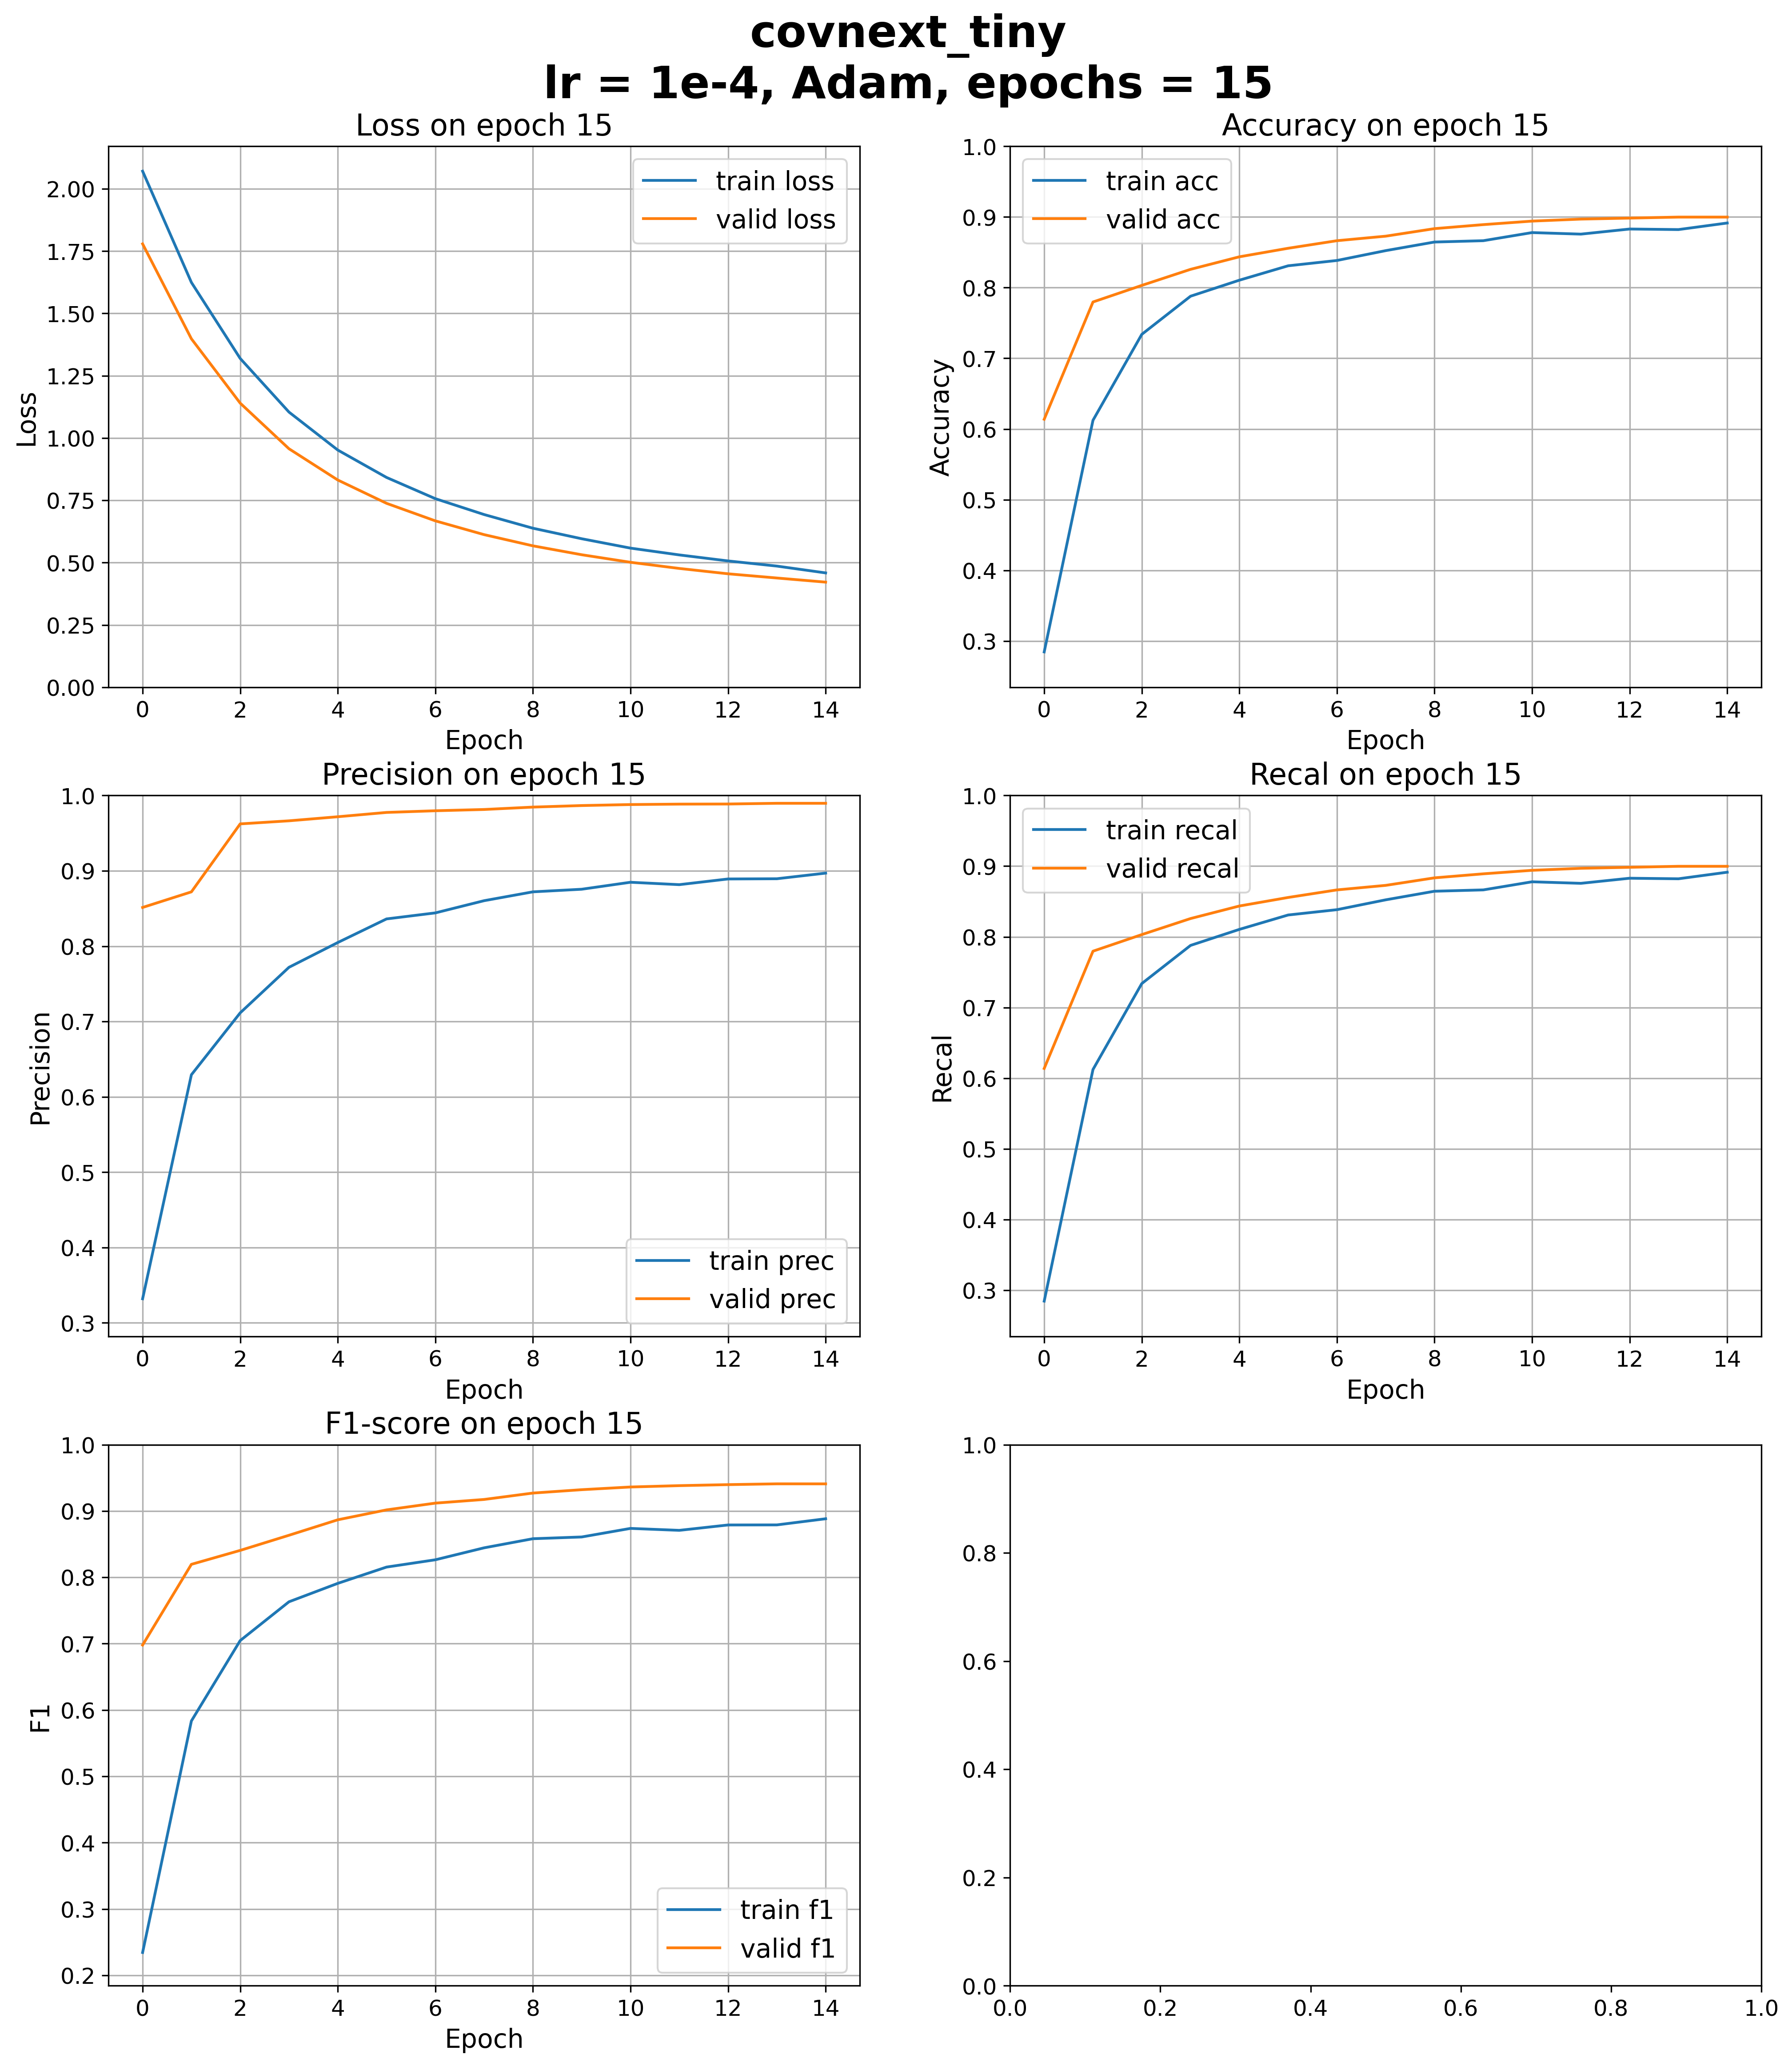

In [83]:
fig = plot_history(history, suptitle="covnext_tiny\nlr = 1e-4, Adam, epochs = 15")

In [ ]:
# fig.savefig("results/img/convnext_tiny.png", bbox_inches="tight", pad_inches=0.5)

In [54]:
from collections import Counter

print("Train class distribution:", Counter(train_ds.targets))
print("Valid class distribution:", Counter(valid_ds.targets))

Train class distribution: Counter({3: 1914, 7: 1562, 5: 1175, 9: 1097, 2: 1057, 8: 998, 0: 828, 4: 589, 1: 505, 6: 405})
Valid class distribution: Counter({7: 240, 3: 210, 2: 170, 9: 163, 8: 150, 5: 142, 0: 140, 6: 70, 4: 69, 1: 50})


7. Распечатай изображение из тестовой выборки и подпиши класс картинки, предсказанный моделью. 

In [98]:
img_path = "data/test/column/375.jpg"
resize = T.Resize((224, 224))
img = resize(io.read_image(img_path) / 255)

In [97]:
classes = {j: i for i, j in train_ds.class_to_idx.items()}
classes

{0: 'altar',
 1: 'apse',
 2: 'bell_tower',
 3: 'column',
 4: 'dome(inner)',
 5: 'dome(outer)',
 6: 'flying_buttress',
 7: 'gargoyle',
 8: 'stained_glass',
 9: 'vault'}

In [117]:
with torch.inference_mode():
    pred_class = classes[
        torch.sigmoid(model(img.unsqueeze(0).to(DEVICE))).argmax().item()
    ]

Text(0.5, 1.0, 'column')

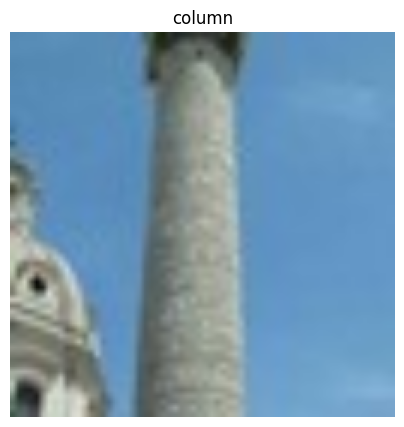

In [118]:
plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(torch.permute(img, (1, 2, 0)))  # [channels, height, width]
plt.axis("off")
plt.title(pred_class)

8. "Разморозь" несоклько слоев базовой модели и вновь обучи ее. Зафиксируй метрику качества для модели. О том, как сделать unfreeze нескольких слоев сразу, а не только последнего, можно почитать тут: [discuss.pytorch.org](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/3)

In [119]:
weights = ConvNeXt_Tiny_Weights.DEFAULT
model2 = convnext_tiny(weights=weights)
model2.to(DEVICE)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [121]:
for param in model2.parameters():
    param.requires_grad = False
for param in model2.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [163]:
model2.classifier[2] = nn.Linear(in_features=768, out_features=10, bias=True)
model2.classifier[2].weight.requires_grad = True
model2.classifier[2].bias.requires_grad = True
model2.classifier[2].reset_parameters()

In [165]:
model2.features[4][1].weight.requires_grad = True
model2.features[4][1].bias.requires_grad = True
model2.features[4][1].reset_parameters()

In [130]:
for param in model2.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [181]:
lr2 = 5e-3
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr2, weight_decay=1e-5)

In [182]:
train_loader2 = DataLoader(
    train_ds,
    batch_size=256,
    generator=GENERATOR,
    shuffle=True,  # перемешиваем данные для обучения
    num_workers=4,  # подстрой под свои CPU-ядра
    # pin_memory=True,  # ускоряет передачу CPU→GPU
    persistent_workers=True,  # не пересоздаёт воркеров на каждой эпохе
    prefetch_factor=2,  # (по умолчанию 2) батчей на воркер вперёд
    drop_last=True,  # убираем неполный батч (оптимальнее для тренировки)
)
valid_loader2 = DataLoader(
    valid_ds,
    batch_size=256,
    generator=GENERATOR,
    shuffle=False,  # валидацию не перемешиваем
    num_workers=4,
    # pin_memory=True,
    persistent_workers=True,
)

In [183]:
history2 = fit_with_mlflow(
    model=model2,
    epochs=20,
    optimizer=optimizer2,
    criterion=criterion,
    train_loader=train_loader2,
    valid_loader=valid_loader2,
    augmentation=True,
)

------------- Epoch 1 -------------
Train: loss 1.5379
accuracy 0.4930, F1-score 0.4499
precision 0.4920, recal 0.4930
Valid: loss 1.0769
accuracy 0.6180, F1-score 0.6913
precision 0.8481, recal 0.6180

-----------------------------------

------------- Epoch 2 -------------
Train: loss 0.9757
accuracy 0.6520, F1-score 0.6373
precision 0.6631, recal 0.6520
Valid: loss 0.9271
accuracy 0.6527, F1-score 0.7308
precision 0.9178, recal 0.6527

-----------------------------------

------------- Epoch 3 -------------
Train: loss 0.7722
accuracy 0.7294, F1-score 0.7215
precision 0.7424, recal 0.7294
Valid: loss 0.9908
accuracy 0.6626, F1-score 0.7468
precision 0.9093, recal 0.6626

-----------------------------------

------------- Epoch 4 -------------
Train: loss 0.6802
accuracy 0.7626, F1-score 0.7561
precision 0.7803, recal 0.7626
Valid: loss 0.8440
accuracy 0.7137, F1-score 0.7923
precision 0.9352, recal 0.7137

-----------------------------------

------------- Epoch 5 -------------
Trai

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7944b51b32e0>
Traceback (most recent call last):
  File "/home/dmitry/elbrus/Phase2/ds-phase-2-git/week1/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/home/dmitry/elbrus/Phase2/ds-phase-2-git/week1/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1623, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "/home/dmitry/elbrus/Phase2/ds-phase-2-git/week1/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1559, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7944b51b32e0>
Traceback (most recent call last):
  File "/home/dmitr

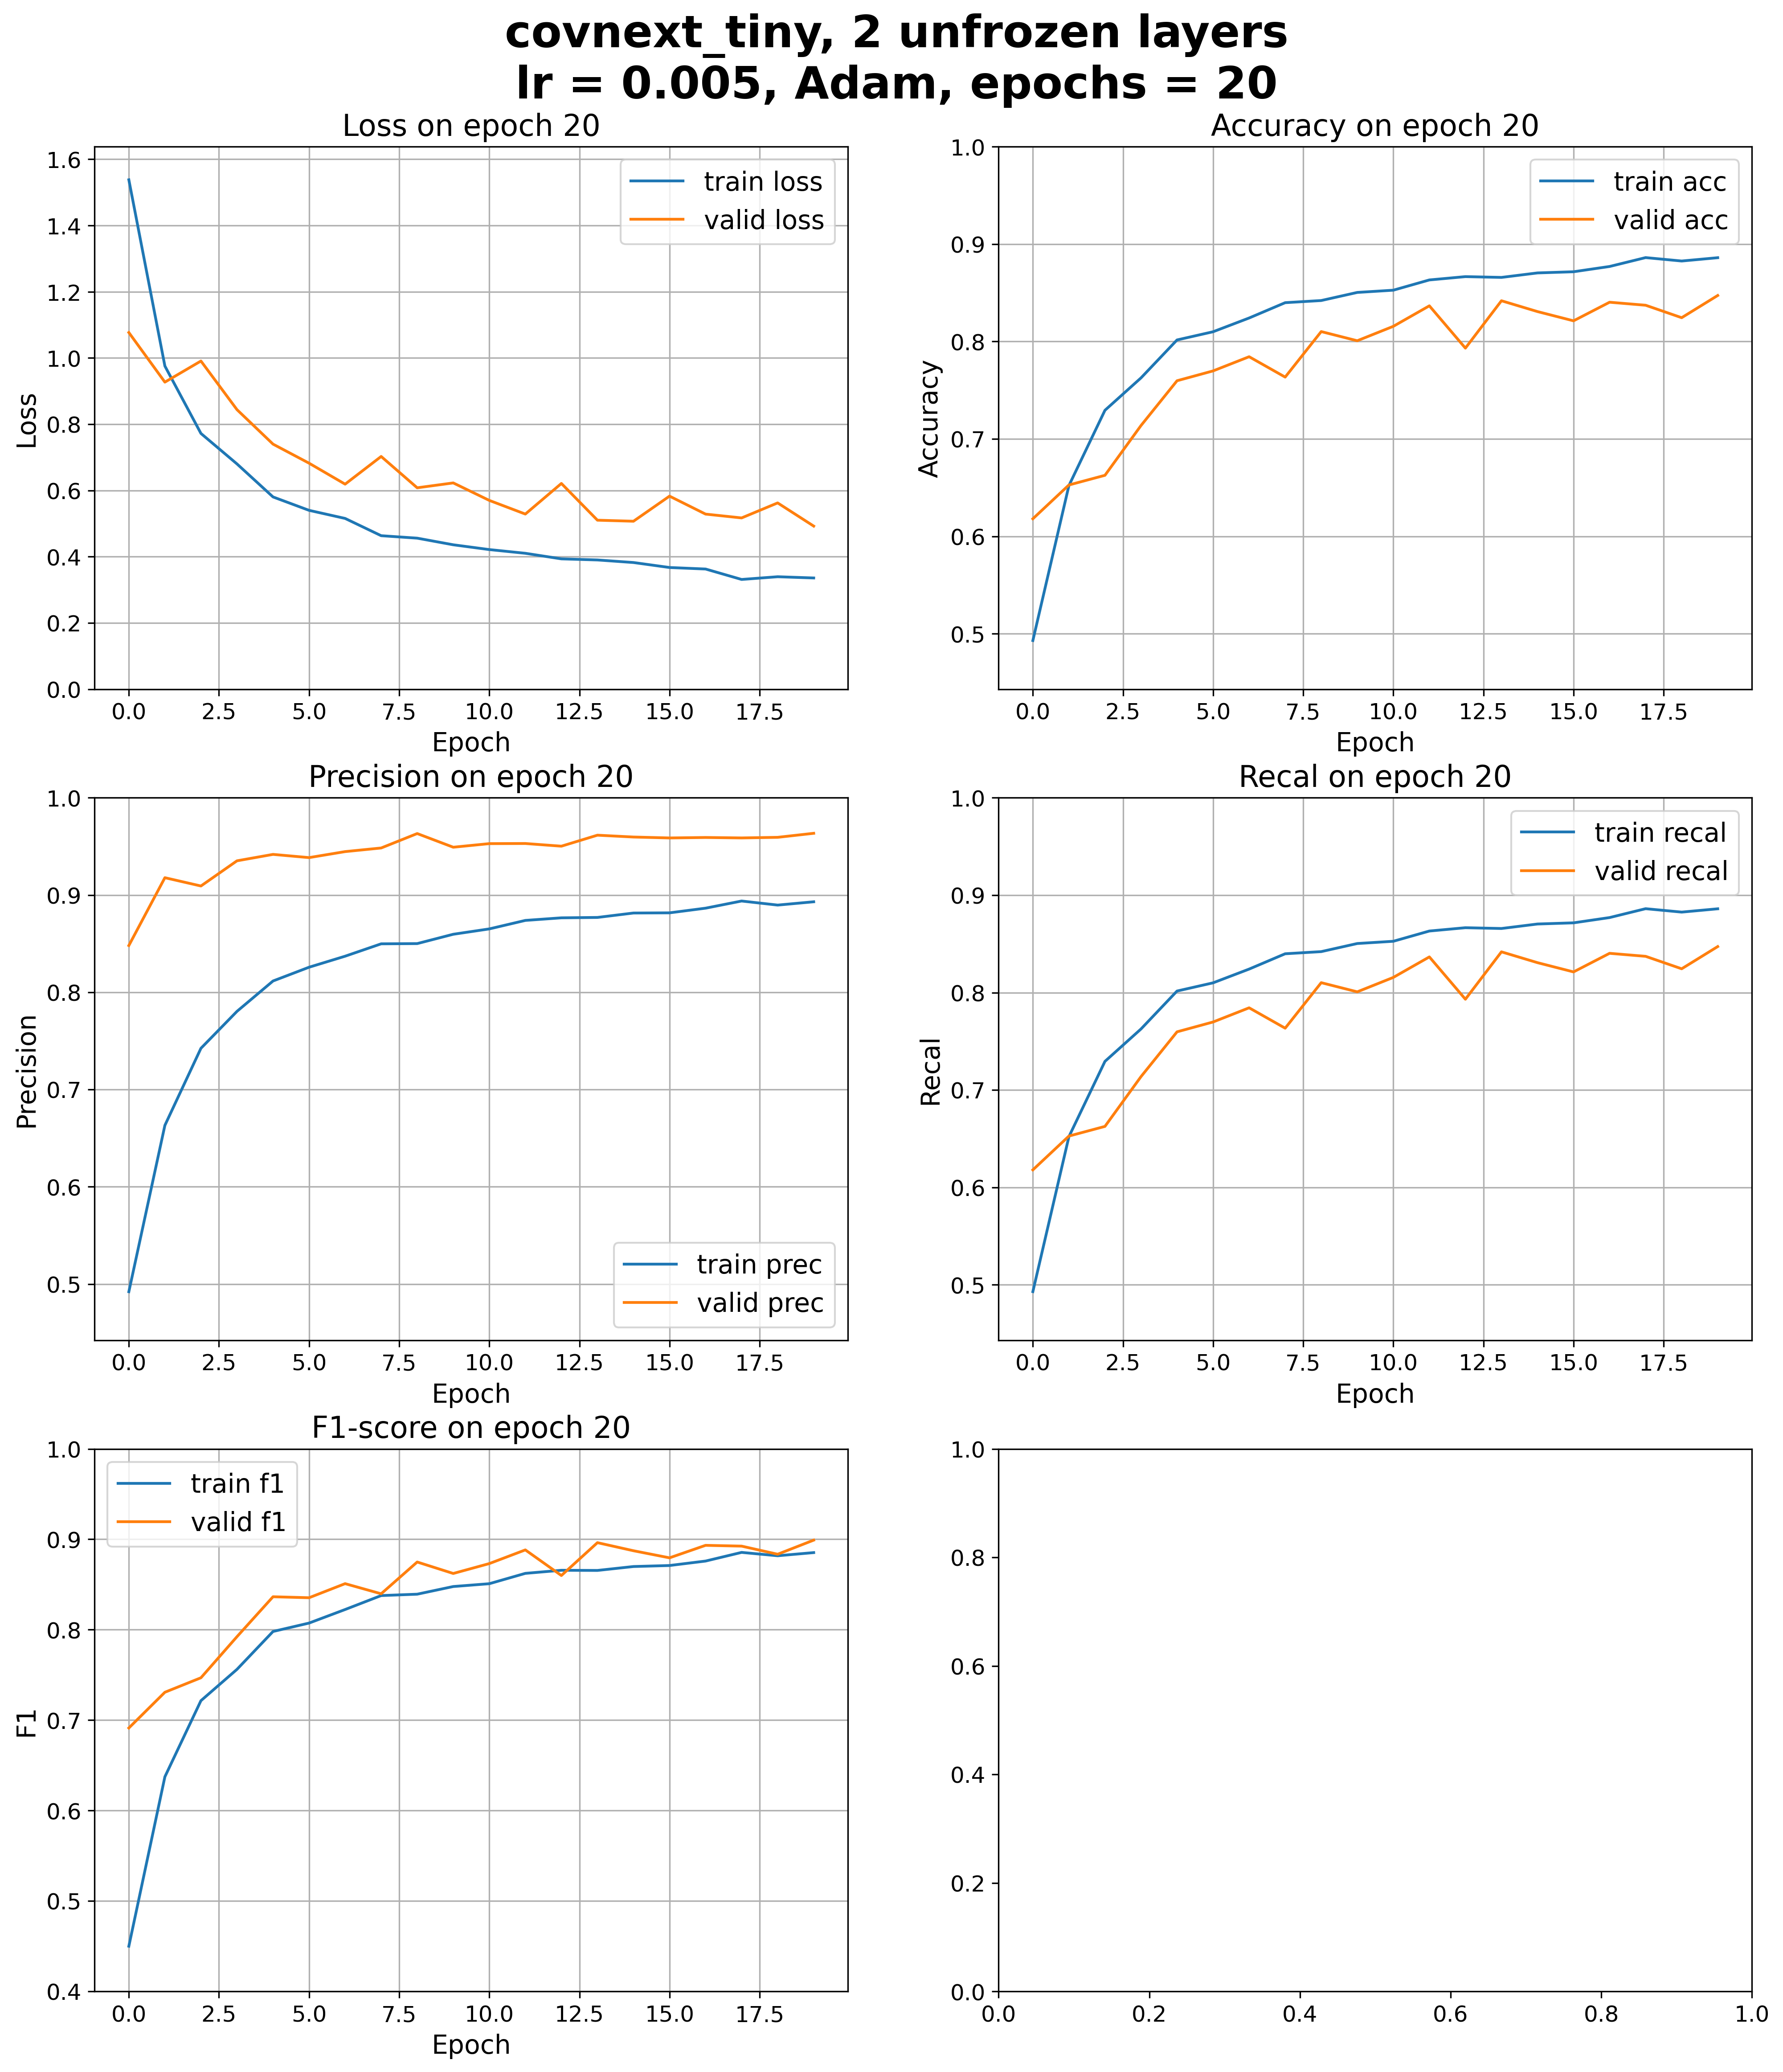

In [184]:
fig2 = plot_history(
    history2, suptitle=f"covnext_tiny, 2 unfrozen layers\nlr = {lr2}, Adam, epochs = 20"
)

In [ ]:
# fig.savefig(
#     "results/img/convnext_tiny_2_layers.png", bbox_inches="tight", pad_inches=0.5
# )

9. Сравни качество двух моделей: предобученной с замененным выходным слоем и дообученной с несколькими размороженными слоями. 

In [ ]:
# code

<img src="https://icons.iconarchive.com/icons/icons8/windows-8/256/Programming-Github-icon.png" width=32 /> Сохрани файл для __github__ и распечатай результат команды `!git status` в ячейке ниже. 

In [ ]:
# code

10. Сохрани модель (пример можно посмотреть [тут](../../learning/aux/model_saving.ipynb) или в [документации](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [ ]:
# code

11. Реализуй функцию, которая на вход принимает путь к файлу, а в ответ возвращает класс объекта. 

In [ ]:
def get_prediction(path: str) -> str:
    pass

12. Сохрани ноутбук на github